In [196]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import xgboost
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import silhouette_score
from sklearn.metrics import make_scorer, r2_score
from sklearn.metrics import classification_report

In [2]:
train_data = pd.read_csv('train_LZdllcl.csv')
test_data = pd.read_csv('test_2umaH9m.csv')
train_data.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


## Exploratory Data Analysis

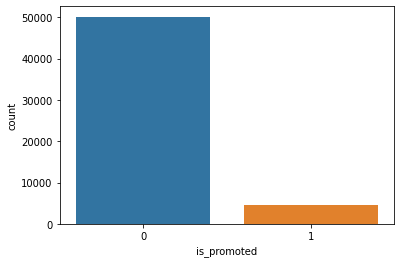

In [3]:
sns.countplot(train_data['is_promoted'])

In [8]:
train_data.isnull().sum()

employee_id             0
department              0
region                  0
education               0
gender                  0
recruitment_channel     0
no_of_trainings         0
age                     0
previous_year_rating    0
length_of_service       0
KPIs_met >80%           0
awards_won?             0
avg_training_score      0
is_promoted             0
dtype: int64

In [5]:
len(train_data)

54808

In [7]:
train_data = train_data.fillna(method = 'bfill')

In [9]:
(train_data['is_promoted'].value_counts() / len(train_data)) * 100

0    91.482995
1     8.517005
Name: is_promoted, dtype: float64

In [173]:
X = train_data[train_data.columns[:-1]]
y = train_data['is_promoted']
t_x = test_data[test_data.columns]
t_x = t_x.fillna(method = 'bfill')

#Pre-processing categorical columns

In [174]:
cat_columns = X[['department','region','education','gender','recruitment_channel','KPIs_met >80%','awards_won?','no_of_trainings']]
t_cat_columns = t_x[['department','region','education','gender','recruitment_channel','KPIs_met >80%','awards_won?','no_of_trainings']]

In [175]:
cat_columns = pd.get_dummies(cat_columns)
t_cat_columns = pd.get_dummies(t_cat_columns)

In [176]:
cat_columns.drop('gender_m',axis = 1,inplace=True)

In [177]:
t_cat_columns.drop('gender_m',axis = 1,inplace=True)

## Handling Numerical Data

In [178]:
num_columns = X[['age','previous_year_rating','length_of_service','avg_training_score']]
t_num_columns = t_x[['age','previous_year_rating','length_of_service','avg_training_score']]

In [179]:
num_columns

,age,previous_year_rating,length_of_service,avg_training_score
0,35,5.0,8,49
1,30,5.0,4,60
2,34,3.0,7,50
3,39,1.0,10,50
4,45,3.0,2,73
...,...,...,...,...
54803,48,3.0,17,78
54804,37,2.0,6,56
54805,27,5.0,3,79
54806,29,1.0,2,45


In [180]:
normalizer = preprocessing.Normalizer(norm ='l2')
normalizer.fit_transform(num_columns)

array([[0.57423365, 0.08203338, 0.1312534 , 0.8039271 ],
       [0.44519011, 0.07419835, 0.05935868, 0.89038021],
       [0.55790206, 0.04922665, 0.11486219, 0.82044421],
       ...,
       [0.32261956, 0.05974436, 0.03584662, 0.94396094],
       [0.54122943, 0.01866308, 0.03732617, 0.83983877],
       [0.48061273, 0.01780047, 0.08900236, 0.8722231 ]])

In [186]:
scaler = StandardScaler()
features_standardized = scaler.fit_transform(num_columns)
t_features_standardized = scaler.fit_transform(t_num_columns)
t_features_standardized

array([[-1.40415005, -0.27123329, -1.14319985,  1.02426301],
       [-0.49261197, -0.27123329, -0.19259047, -0.91437691],
       [-0.49261197, -1.85376431, -0.43024281, -1.21262921],
       ...,
       [-1.1437106 ,  0.52003222, -0.43024281, -0.98893999],
       [-1.01349087,  1.31129774, -1.14319985,  0.5023215 ],
       [ 0.67936557,  1.31129774, -0.19259047,  1.9190199 ]])

In [187]:
X = pd.concat([cat_columns,pd.DataFrame(features_standardized)],axis = 1, sort=False)
t_x = pd.concat([t_cat_columns,pd.DataFrame(t_features_standardized)],axis = 1, sort=False)
t_x

,KPIs_met >80%,awards_won?,no_of_trainings,department_Analytics,department_Finance,department_HR,department_Legal,department_Operations,department_Procurement,department_R&D,department_Sales & Marketing,department_Technology,region_region_1,region_region_10,region_region_11,region_region_12,region_region_13,region_region_14,region_region_15,region_region_16,region_region_17,region_region_18,region_region_19,region_region_2,region_region_20,region_region_21,region_region_22,region_region_23,region_region_24,region_region_25,region_region_26,region_region_27,region_region_28,region_region_29,region_region_3,region_region_30,region_region_31,region_region_32,region_region_33,region_region_34,region_region_4,region_region_5,region_region_6,region_region_7,region_region_8,region_region_9,education_Bachelor's,education_Below Secondary,education_Master's & above,gender_f,recruitment_channel_other,recruitment_channel_referred,recruitment_channel_sourcing,0,1,2,3
0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,-1.404150,-0.271233,-1.143200,1.024263
1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,-0.492612,-0.271233,-0.192590,-0.914377
2,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,-0.492612,-1.853764,-0.430243,-1.212629
3,0,0,3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,-0.492612,-1.062499,0.758019,0.129506
4,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,-0.622832,0.520032,0.282714,-0.168746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23485,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,-1.404150,-0.271233,-1.143200,-0.168746
23486,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,-0.492612,-0.271233,0.282714,0.800574
23487,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,-1.143711,0.520032,-0.430243,-0.988940
23488,0,0,3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,-1.013491,1.311298,-1.143200,0.502321


In [124]:
os =  RandomOverSampler(ratio=0.689)

In [83]:
X_train_res, y_train_res = os.fit_sample(X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [84]:
X_train_res.shape,y_train_res.shape

((84686, 57), (84686,))

In [77]:
(pd.Series(y_train_res).value_counts() / len(y_train_res)) * 100

0    59.206953
1    40.793047
dtype: float64

In [90]:
X_train,X_test,y_train,y_test = train_test_split(X_train_res,y_train_res,test_size = 0.3,random_state = 1)

In [96]:
logistic_regression = LogisticRegressionCV(
  penalty='l2', Cs=10, random_state=0, n_jobs=-1,solver="sag")
# Train model
model = logistic_regression.fit(X_train, y_train)

In [97]:
y_pred = model.predict(X_test)
accuracy_score(y_test,y_pred)

0.7835550657325041

In [101]:
logistic = LogisticRegression()

penalty = ["l1", "l2"]

C = np.logspace(0, 4, 100)

hyperparameters = dict(C=C, penalty=penalty)

gridsearch = GridSearchCV(logistic, hyperparameters, cv=5, n_jobs=-1, verbose=1)

best_model = gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 2000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-1)]: Done 2446 tasks      | elapsed: 19.7min
[Parallel(n_jobs=-1)]: Done 3196 tasks      | elapsed: 25.5min
[Parallel(n_jobs=-1)]: Done 4046 tasks      | elapsed: 32.0min
[Parallel(n_jobs=-1)]: Done 4996 tasks      | elapsed: 39.4min
[Parallel(n_jobs=-1)]: Done 6046 tasks      | elapsed: 47.6min
[Parallel(n_jobs=-1)]: Done 7196 tasks      | elapsed: 56.6min
[Parallel(n_jobs=-1)]: Done 8446 tasks      | elapsed: 66.3min
[Parallel(n_jobs=-1)]: Done 9796 tasks      | elapsed: 76.4min
[Parallel(n_jobs=-1)]: Done 10000 out of 10000

In [149]:
classifier=xgboost.XGBClassifier()

In [153]:
params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
    
}

In [154]:
random_search=RandomizedSearchCV(classifier,param_distributions=params,n_iter=5,scoring='roc_auc',n_jobs=-1,cv=5,verbose=3)

In [155]:
random_search.fit(X_train,y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  2.5min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, sc...
                                           verbosity=1),
                   iid='deprecated', n_iter=5, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0

In [157]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0.4,
              learning_rate=0.25, max_delta_step=0, max_depth=15,
              min_child_weight=5, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [159]:
classifier = xgboost.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0.4,
              learning_rate=0.25, max_delta_step=0, max_depth=15,
              min_child_weight=5, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

classifier.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0.4,
              learning_rate=0.25, max_delta_step=0, max_depth=15,
              min_child_weight=5, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [166]:
y_pred = classifier.predict(X_test)
accuracy_score(y_test,y_pred)

0.9274974415492403

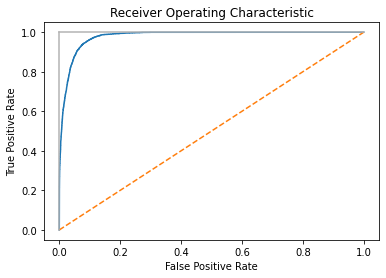

In [201]:
target_probabilities = classifier.predict_proba(X_test)[:,1]

false_positive_rate, true_positive_rate, threshold = roc_curve(y_test,
target_probabilities)

plt.title("Receiver Operating Characteristic")
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

In [197]:
print(classification_report(y_test,
                y_pred,
                target_names=['is promoted','not promoted']))

              precision    recall  f1-score   support

 is promoted       0.97      0.91      0.94     15116
not promoted       0.88      0.95      0.91     10290

    accuracy                           0.93     25406
   macro avg       0.92      0.93      0.93     25406
weighted avg       0.93      0.93      0.93     25406



In [189]:
predicted_values = classifier.predict(np.asarray(t_x))

In [190]:
predicted_values

array([0, 0, 0, ..., 0, 0, 1])

In [193]:
sd = pd.read_csv('sample_submission_M0L0uXE.csv')

In [194]:
sd['is_promoted'] = predicted_values

In [195]:
sd.to_csv('hr_submission_4.csv')

In [192]:
pd.Series(predicted_values).value_counts()

0    20529
1     2961
dtype: int64

In [185]:
t_x

,KPIs_met >80%,awards_won?,no_of_trainings,department_Analytics,department_Finance,department_HR,department_Legal,department_Operations,department_Procurement,department_R&D,department_Sales & Marketing,department_Technology,region_region_1,region_region_10,region_region_11,region_region_12,region_region_13,region_region_14,region_region_15,region_region_16,region_region_17,region_region_18,region_region_19,region_region_2,region_region_20,region_region_21,region_region_22,region_region_23,region_region_24,region_region_25,region_region_26,region_region_27,region_region_28,region_region_29,region_region_3,region_region_30,region_region_31,region_region_32,region_region_33,region_region_34,region_region_4,region_region_5,region_region_6,region_region_7,region_region_8,region_region_9,education_Bachelor's,education_Below Secondary,education_Master's & above,gender_f,recruitment_channel_other,recruitment_channel_referred,recruitment_channel_sourcing,0,1,2,3
0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,-1.404150,-0.271233,-1.143200,1.024263
1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,-0.492612,-0.271233,-0.192590,-0.914377
2,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,-0.492612,-1.853764,-0.430243,-1.212629
3,0,0,3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,-0.492612,-1.062499,0.758019,0.129506
4,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,-0.622832,0.520032,0.282714,-0.168746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23485,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,-1.404150,-0.271233,-1.143200,-0.168746
23486,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,-0.492612,-0.271233,0.282714,0.800574
23487,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,-1.143711,0.520032,-0.430243,-0.988940
23488,0,0,3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,-1.013491,1.311298,-1.143200,0.502321
